# Milestone 2

## Time Series Modelling

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df1=pd.read_excel(r'C:\Users\abhig\Documents\Springboard\FutureCart\Datasets\ProductA.xlsx')
df2=pd.read_excel(r'C:\Users\abhig\Documents\Springboard\FutureCart\Datasets\ProductA_google_clicks.xlsx')
df3=pd.read_excel(r'C:\Users\abhig\Documents\Springboard\FutureCart\Datasets\ProductA_fb_impressions.xlsx')

new_df1=pd.merge(df1, df2, on='Day Index', how='left')

df=pd.merge(new_df1, df3, on='Day Index', how='left')# datset combining all 3 datasets

In [3]:
df.head()

,Day Index,Quantity,Clicks,Impressions
0,2021-12-01,14,445,620
1,2021-12-02,10,433,890
2,2021-12-03,13,424,851
3,2021-12-04,22,427,881
4,2021-12-05,33,451,678


In [4]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df_clean = df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]

print("Original DataFrame:")
print(df)
print("\nDataFrame after removing outliers:")
print(df_clean)

Original DataFrame:
     Day Index  Quantity  Clicks  Impressions
0   2021-12-01        14     445          620
1   2021-12-02        10     433          890
2   2021-12-03        13     424          851
3   2021-12-04        22     427          881
4   2021-12-05        33     451          678
..         ...       ...     ...          ...
207 2022-06-26        13     114         1218
208 2022-06-27        16     106         1311
209 2022-06-28        13     109          885
210 2022-06-29        16      60         1000
211 2022-06-30         8      65          875

[212 rows x 4 columns]

DataFrame after removing outliers:
     Day Index  Quantity  Clicks  Impressions
0   2021-12-01        14     445          620
1   2021-12-02        10     433          890
2   2021-12-03        13     424          851
3   2021-12-04        22     427          881
5   2021-12-06        12     429          995
..         ...       ...     ...          ...
207 2022-06-26        13     114         1218


In [5]:
df=df_clean
df.head()

,Day Index,Quantity,Clicks,Impressions
0,2021-12-01,14,445,620
1,2021-12-02,10,433,890
2,2021-12-03,13,424,851
3,2021-12-04,22,427,881
5,2021-12-06,12,429,995


df is the final data with no outliers and missing values

<Axes: >

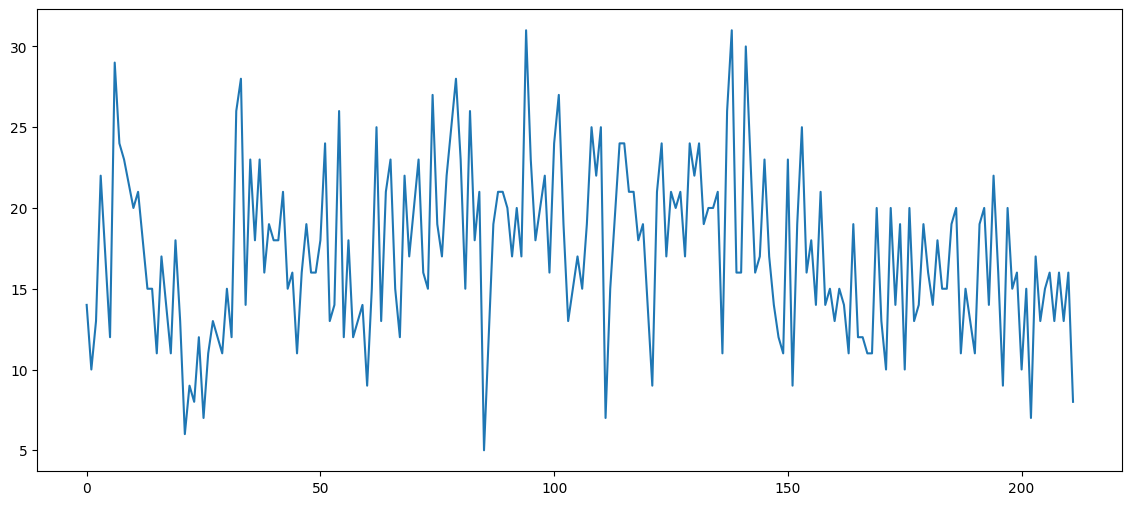

In [7]:
df['Quantity'].plot(figsize=(14,6))

## Stationarity Check

In [6]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Quantity']) #storing the test results in result

print('ADF Statistic:', result[0])  # Test statistic; helps determine stationarity
print('p-value:', result[1])       # p-value; used to decide on rejecting the null hypothesis
#print('Critical Values:', result[4])  # Critical values for different significance levels

for key, value in result[4].items():
    print(f'Critical Value ({key}): {value}')

print('Output: ')
if result[1] < 0.05:
    print("    Reject the null hypothesis: The series is stationary.")
else:
    print("    Fail to reject the null hypothesis: The series is non-stationary.")

ADF Statistic: -4.516446455668561
p-value: 0.00018361360605353083
Critical Value (1%): -3.462980134086401
Critical Value (5%): -2.875885461947131
Critical Value (10%): -2.5744164898444515
Output: 
    Reject the null hypothesis: The series is stationary.


## Plotting ACF and PACF

Autocorrelation (ACF) and Partial Autocorrelation (PACF) plots are essential tools for analyzing dependencies in a time series, especially when identifying the parameters for ARIMA models or understanding the structure of your data.

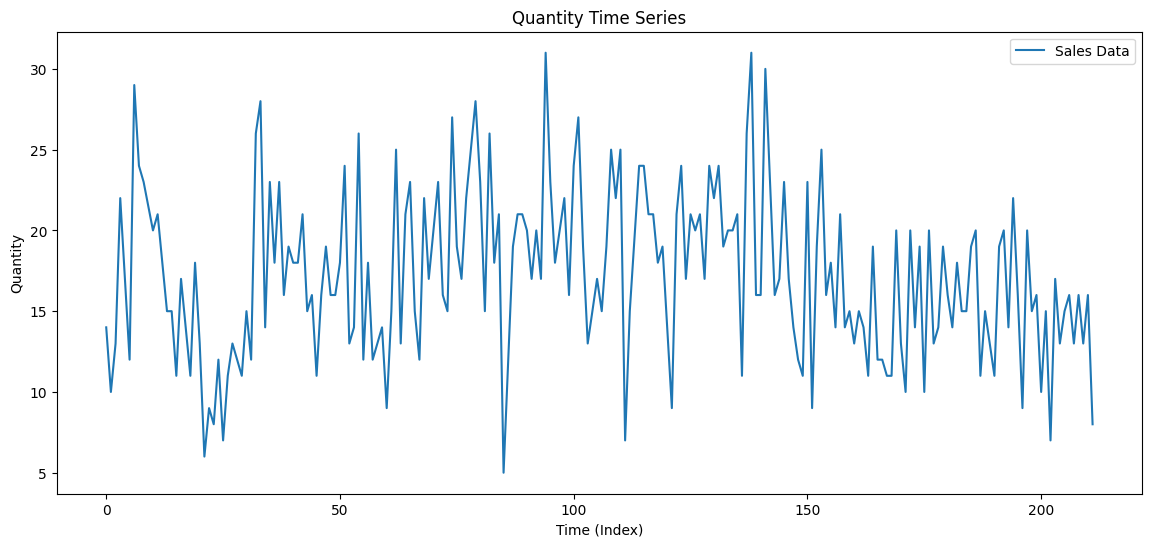

<Figure size 1000x600 with 0 Axes>

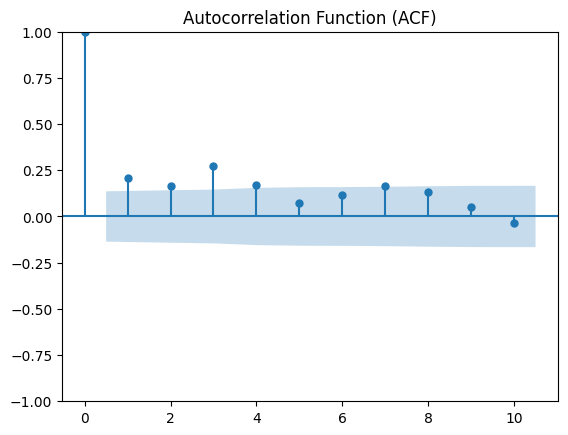

<Figure size 1000x600 with 0 Axes>

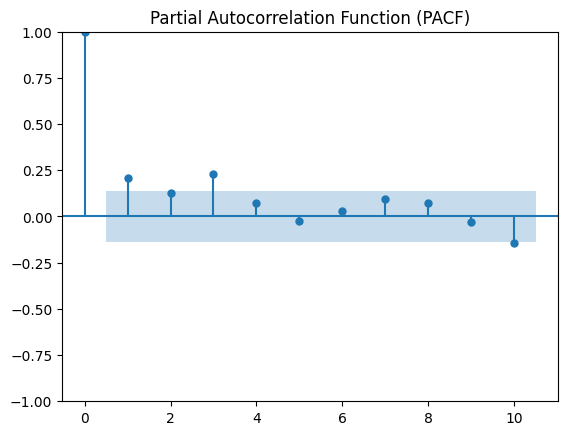

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(14, 6))
plt.plot(df['Quantity'], label='Sales Data')
plt.title('Quantity Time Series')
plt.xlabel('Time (Index)')
plt.ylabel('Quantity')
plt.legend()
plt.show()

# Plot ACF (Autocorrelation Function)
plt.figure(figsize=(10, 6))
plot_acf(df['Quantity'], lags=10, title="Autocorrelation Function (ACF)")
plt.show()

# Plot PACF (Partial Autocorrelation Function)
plt.figure(figsize=(10, 6))
plot_pacf(df['Quantity'], lags=10, title="Partial Autocorrelation Function (PACF)", method='ywm')
plt.show()

**Key Observations from the ACF Plot:**
1.The first lag (lag 1) shows a significant spike, indicating a strong correlation with its immediate past value.

-Subsequent lags decay gradually and remain within the confidence interval (the blue shaded area).

-There is no sudden cutoff after a specific lag.

**Key Observations from the PACF Plot:**
1. The first lag (lag 1) shows a significant spike, indicating a strong correlation with the immediate past value.
2. Subsequent lags show no significant spikes and remain within the confidence interval (the blue shaded area).
3. There is a sudden cutoff after lag 1, which means the partial correlation becomes insignificant for higher lags.


## Train Test Split

The process of splitting your time series data into training and testing subsets to evaluate model performance.It is to ensure the model is evaluated on unseen data (test set), simulating real-world forecasting scenarios.

In [7]:
# Sort the dataset by the date column
data = df.sort_values(by='Day Index')  

# Define train-test split 
train_size = int(0.7 * len(data))  # 80% for training

# Split the data
train = data.iloc[:train_size]  # First 80% rows - train
test = data.iloc[train_size:]   # Remaining 20% rows - test

print(f"Train size: {len(train)}, Test size: {len(test)}")

# Define the train and test datasets for the exogenous variables (independent variables)
train_exog = data[['Impressions', 'Clicks']][:train_size]
test_exog =  data[['Impressions', 'Clicks']][train_size:]


Train size: 144, Test size: 63


In [15]:
train.head()

,Day Index,Quantity,Clicks,Impressions,rolling_mean,rolling_std
0,2021-12-01,14,445,620,NaN,NaN
1,2021-12-02,10,433,890,NaN,NaN
2,2021-12-03,13,424,851,NaN,NaN
3,2021-12-04,22,427,881,NaN,NaN
5,2021-12-06,12,429,995,NaN,NaN


In [16]:
test.head()

,Day Index,Quantity,Clicks,Impressions,rolling_mean,rolling_std
149,2022-04-29,11,131,1323,19.083333,6.761634
150,2022-04-30,23,282,1394,18.833333,6.534292
151,2022-05-01,9,274,1834,17.000000,5.862051
152,2022-05-02,19,154,1906,17.250000,5.879471
153,2022-05-03,25,133,1743,18.000000,6.266796


## Modelling

## AR Model

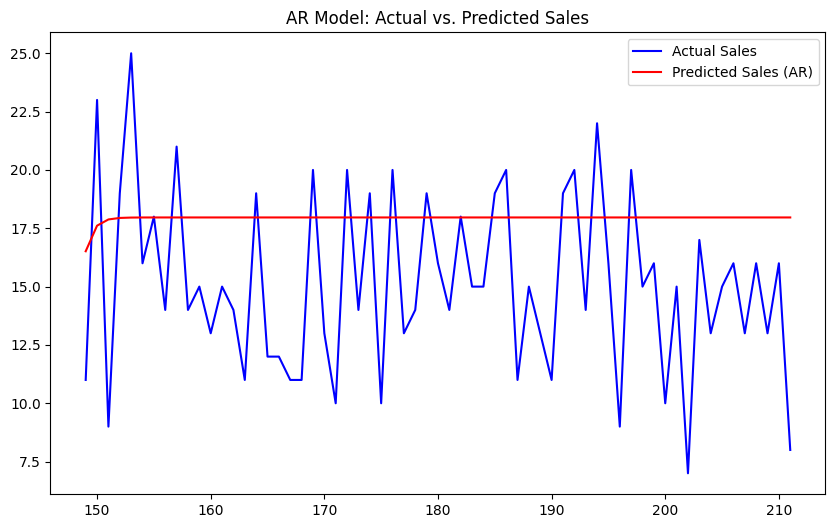

Mean Absolute Error (MAE): 4.029659361274381
Mean Squared Error (MSE): 22.684517328664562
Root Mean Squared Error (RMSE): 4.76282661123251
Mean Percentage Difference: 32.15971505708574%


In [8]:
import warnings
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
warnings.filterwarnings('ignore')  # Ignore all warnings


# Fit the ARIMA model (AR=0, I=0, MA=1)
ar_model = ARIMA(train['Quantity'], order=(1, 0, 0))
ar_fitted_model = ar_model.fit()

# Predict on the test data
predictions = ar_fitted_model.forecast(steps=len(test))

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Quantity'], label='Actual Sales', color='blue')
plt.plot(test.index, predictions, label='Predicted Sales (AR)', color='red')
plt.title('AR Model: Actual vs. Predicted Sales')
plt.legend()
plt.show()

# Calculate MAE
mae = mean_absolute_error(test['Quantity'], predictions)

#calculate MSE
mse = mean_squared_error(test['Quantity'], predictions)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Quantity'], predictions))

# Calculate Percentage Difference
percentage_diff = np.abs((test['Quantity'] - predictions) / test['Quantity']) * 100
mean_percentage_diff = percentage_diff.mean()

# Display the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Percentage Difference: {mean_percentage_diff}%")


**Insights for AR Model:**
1. The model shows moderate performance, with an average error (MAE) of 4.03 and a high relative error (32.16%).
2. The relatively high RMSE suggests that outliers or larger deviations may be affecting predictions.

## MA Model

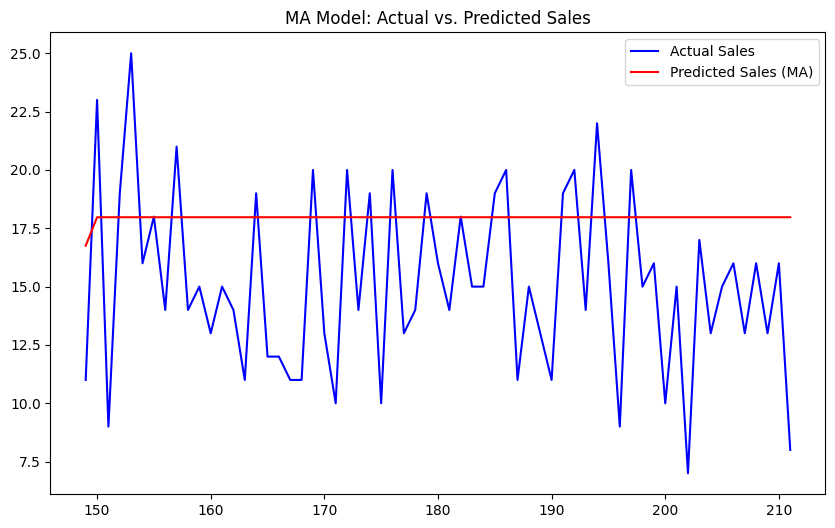

Mean Absolute Error (MAE): 4.032763000191929
Mean Squared Error (MSE): 22.74395996448145
Root Mean Squared Error (RMSE): 4.769062797288525
Mean Percentage Difference: 32.197493017965435%


In [9]:
# Fit the ARIMA model (AR=0, I=0, MA=1)
ma_model = ARIMA(train['Quantity'], order=(0, 0, 1))
ma_fitted_model = ma_model.fit()

# Predict on the test data
predictions = ma_fitted_model.forecast(steps=len(test))

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Quantity'], label='Actual Sales', color='blue')
plt.plot(test.index, predictions, label='Predicted Sales (MA)', color='red')
plt.title('MA Model: Actual vs. Predicted Sales')
plt.legend()
plt.show()

# Calculate MAE
mae = mean_absolute_error(test['Quantity'], predictions)

#calculate MSE
mse = mean_squared_error(test['Quantity'], predictions)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Quantity'], predictions))

# Calculate Percentage Difference
percentage_diff = np.abs((test['Quantity'] - predictions) / test['Quantity']) * 100
mean_percentage_diff = percentage_diff.mean()

# Display the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Percentage Difference: {mean_percentage_diff}%")


**Insights for the MA Model:**
1. The MA model's slightly higher MSE and RMSE suggest it may not handle large deviations as effectively as the AR model in this case.

## ARIMA MODEL

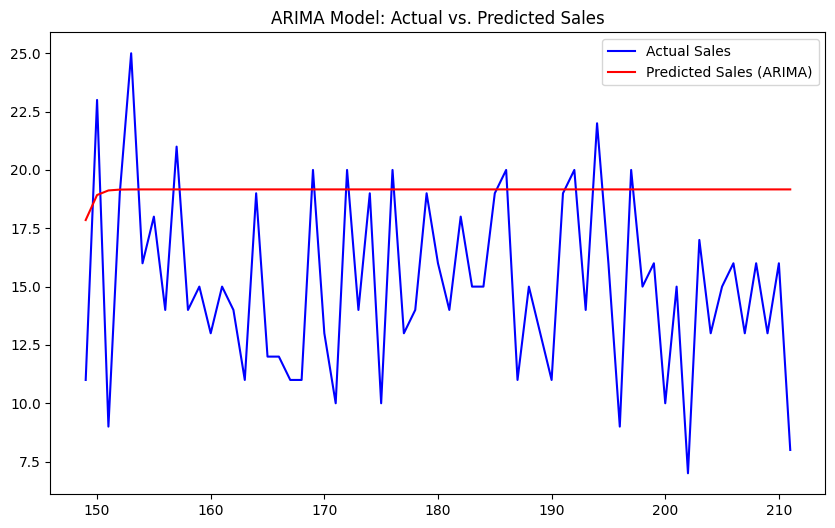

Mean Absolute Error (MAE): 4.650972430080794
Mean Squared Error (MSE): 30.941893452909827
Root Mean Squared Error (RMSE): 5.562543793347593
Mean Percentage Difference: 37.47710499178331%


In [10]:
# Fit the ARIMA model (AR=1, I=1, MA=1)
arima_model = ARIMA(train['Quantity'], order=(1, 1, 1))
arima_fitted_model = arima_model.fit()

# Predict on the test data
predictions = arima_fitted_model.forecast(steps=len(test))

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Quantity'], label='Actual Sales', color='blue')
plt.plot(test.index, predictions, label='Predicted Sales (ARIMA)', color='red')
plt.title('ARIMA Model: Actual vs. Predicted Sales')
plt.legend()
plt.show()

# Calculate MAE
mae = mean_absolute_error(test['Quantity'], predictions)

#calculate MSE
mse = mean_squared_error(test['Quantity'], predictions)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Quantity'], predictions))

# Calculate Percentage Difference
percentage_diff = np.abs((test['Quantity'] - predictions) / test['Quantity']) * 100
mean_percentage_diff = percentage_diff.mean()

# Display the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Percentage Difference: {mean_percentage_diff}%")


**Insights from ARIMA:**
1. MAE, MSE, RMSE: ARIMA performs worse than AR and MA models across all these metrics, with higher absolute, squared, and root errors.
2. Mean Percentage Difference: ARIMA also has a significantly higher percentage difference, indicating poorer relative performance.


## SARIMA MODEL

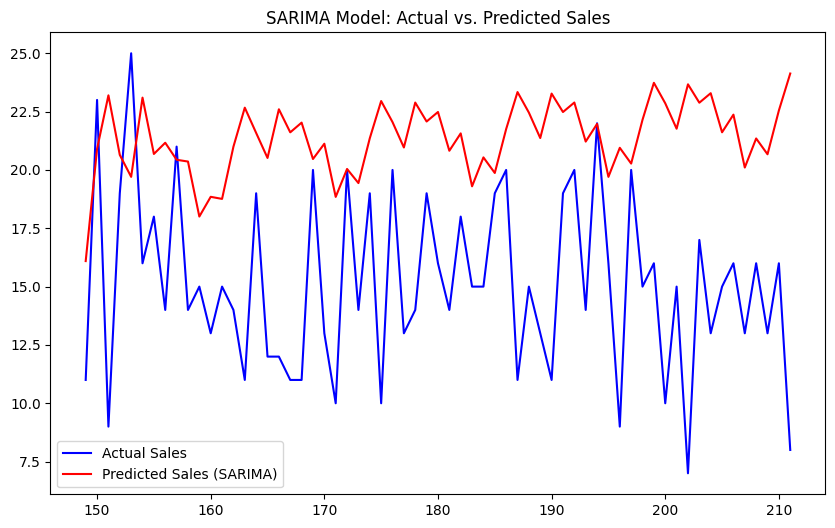

Mean Absolute Error (MAE): 6.499570305915901
Mean Squared Error (MSE): 58.12189397721083
Root Mean Squared Error (RMSE): 7.623771637267923
Mean Percentage Difference: 51.40288134164106%


In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit the SARIMA model (AR=1, I=1, MA=1)
sarima_model = SARIMAX(train['Quantity'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fitted_model = sarima_model.fit()

# Predict on the test data
predictions = sarima_fitted_model.forecast(steps=len(test))

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Quantity'], label='Actual Sales', color='blue')
plt.plot(test.index, predictions, label='Predicted Sales (SARIMA)', color='red')
plt.title('SARIMA Model: Actual vs. Predicted Sales')
plt.legend()
plt.show()

# Calculate MAE
mae = mean_absolute_error(test['Quantity'], predictions)

#calculate MSE
mse = mean_squared_error(test['Quantity'], predictions)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Quantity'], predictions))

# Calculate Percentage Difference
percentage_diff = np.abs((test['Quantity'] - predictions) / test['Quantity']) * 100
mean_percentage_diff = percentage_diff.mean()

# Display the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Percentage Difference: {mean_percentage_diff}%")


Very poor performance by SARIMA.

## ARIMAX MODEL

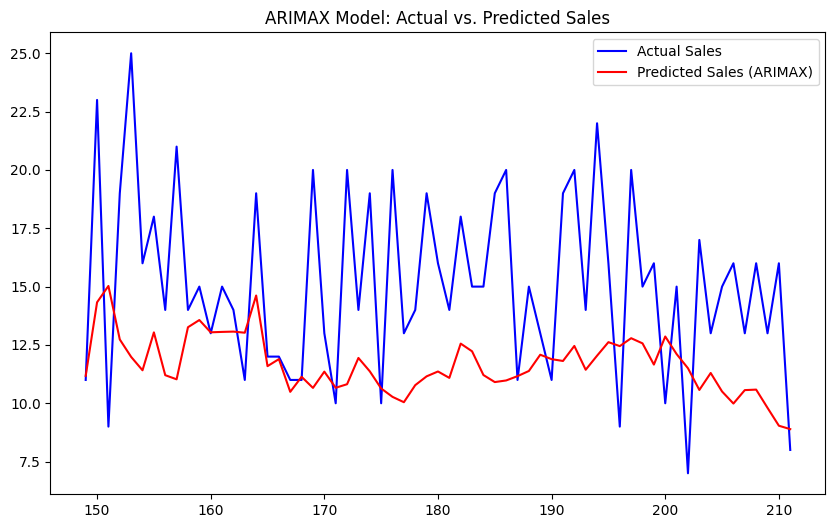

Mean Absolute Error (MAE): 4.160911321208081
Mean Squared Error (MSE): 27.09042132470047
Root Mean Squared Error (RMSE): 5.204845946298552
Mean Percentage Difference: 25.35791245877169%


In [12]:
# Fit the ARIMA model (AR=1, I=1, MA=1)
arimax_model = ARIMA(train['Quantity'], order=(1, 1, 1), exog=train_exog)
arimax_fitted_model = arimax_model.fit()

# Predict on the test data
predictions = arimax_fitted_model.forecast(steps=len(test), exog=test_exog)

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Quantity'], label='Actual Sales', color='blue')
plt.plot(test.index, predictions, label='Predicted Sales (ARIMAX)', color='red')
plt.title('ARIMAX Model: Actual vs. Predicted Sales')
plt.legend()
plt.show()

# Calculate MAE
mae = mean_absolute_error(test['Quantity'], predictions)

#calculate MSE
mse = mean_squared_error(test['Quantity'], predictions)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Quantity'], predictions))

# Calculate Percentage Difference
percentage_diff = np.abs((test['Quantity'] - predictions) / test['Quantity']) * 100
mean_percentage_diff = percentage_diff.mean()

# Display the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Percentage Difference: {mean_percentage_diff}%")


**Insights for ARIMAX Model:**

Although ARIMAX handles relative errors well, its absolute errors (MAE, MSE, RMSE) could be reduced further, potentially by refining model parameters or reassessing the exogenous variables.

## SARIMAX MODEL

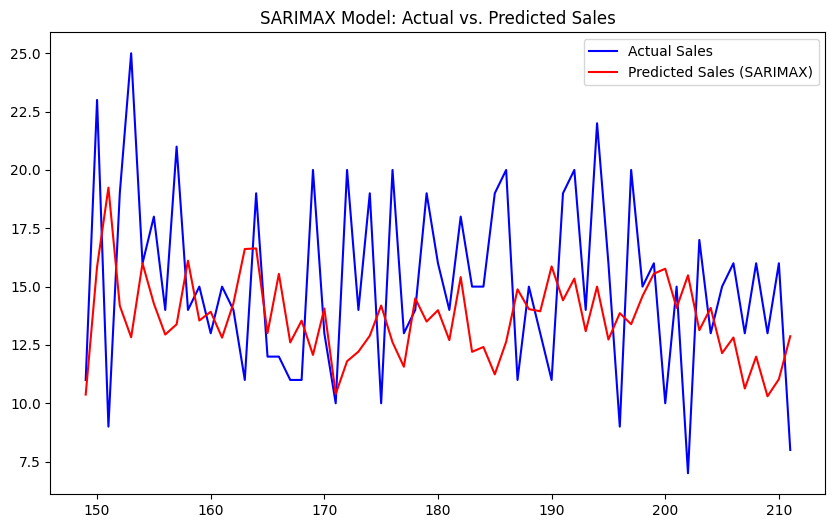

Mean Absolute Error (MAE): 3.6573521508511213
Mean Squared Error (MSE): 20.953705626301968
Root Mean Squared Error (RMSE): 4.577521777807504
Mean Percentage Difference: 22.259742036827635%


In [13]:

# Fit the SARIMA model (AR=1, I=1, MA=1)
sarimax_model = SARIMAX(train['Quantity'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12), exog=train_exog)
sarimax_fitted_model = sarimax_model.fit()

# Predict on the test data
predictions = sarimax_fitted_model.forecast(steps=len(test), exog=test_exog)

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Quantity'], label='Actual Sales', color='blue')
plt.plot(test.index, predictions, label='Predicted Sales (SARIMAX)', color='red')
plt.title('SARIMAX Model: Actual vs. Predicted Sales')
plt.legend()
plt.show()

# Calculate MAE
mae = mean_absolute_error(test['Quantity'], predictions)

#calculate MSE
mse = mean_squared_error(test['Quantity'], predictions)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Quantity'], predictions))

# Calculate Percentage Difference
percentage_diff = np.abs((test['Quantity'] - predictions) / test['Quantity']) * 100
mean_percentage_diff = percentage_diff.mean()

# Display the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Percentage Difference: {mean_percentage_diff}%")


**Insights for SARIMAX Model:**
-  SARIMAX achieves the best results across all metrics, suggesting that both seasonal patterns and external variables play a critical role in improving accuracy.
-  Suggestions : Fine-tune seasonal (P, D, Q, m) and non-seasonal (p, d, q) parameters.

In [14]:
# Evaluation metrics before hyperparameter tuning
metrics_before = pd.DataFrame({
    "Model": ["AR", "MA", "ARIMA", "SARIMA", "ARIMAX", "SARIMAX"],
    "MAE": [4.029659361274381, 4.032763000191929, 4.650972430080794, 6.499570305915901, 4.160911321208081, 3.6573521508511213],
    "RMSE": [4.76282661123251, 4.769062797288525, 5.562543793347593, 7.623771637267923, 5.204845946298552, 4.577521777807504],
    "MSE": [22.684517328664562, 22.74395996448145, 30.941893452909827, 58.12189397721083, 27.09042132470047, 20.953705626301968],
    "PD": [32.15971505708574, 32.197493017965435, 37.47710499178331, 51.40288134164106,  25.35791245877169, 22.259742036827635],
})
print("Metrics Before Tuning")
print(metrics_before)

Metrics Before Tuning
     Model       MAE      RMSE        MSE         PD
0       AR  4.029659  4.762827  22.684517  32.159715
1       MA  4.032763  4.769063  22.743960  32.197493
2    ARIMA  4.650972  5.562544  30.941893  37.477105
3   SARIMA  6.499570  7.623772  58.121894  51.402881
4   ARIMAX  4.160911  5.204846  27.090421  25.357912
5  SARIMAX  3.657352  4.577522  20.953706  22.259742


The SARIMAX model consistently outperforms all others, achieving the lowest MAE, RMSE, MSE, and percentage error, thanks to its ability to account for seasonality and exogenous variables. While simpler models like AR and MA perform well for basic datasets, SARIMAX’s comprehensive approach makes it the best choice. Further fine-tuning of seasonal and exogenous parameters can enhance its accuracy even more.

In [15]:
# Function to plot residuals
def plot_residuals(model_fit, model_name):
    residuals = model_fit.resid
    plt.figure(figsize=(10, 6))
    plt.plot(residuals, label='Residuals', color='purple')
    plt.axhline(0, linestyle='--', color='gray', linewidth=1)
    plt.title('Residual Plot')
    plt.legend()
    plt.show()

## HYPERPARAMETER TUNING

## Hyperparameters for ARIMA

In [17]:
import optuna

In [19]:
import warnings
warnings.filterwarnings('ignore')  # Ignore all warnings

# ARIMA Hyperparameter Tuning
def objective_arima(trial):
    # Hyperparameters for ARIMA
    p = trial.suggest_int("p", 0, 5)
    d = trial.suggest_int("d", 0, 2)
    q = trial.suggest_int("q", 0, 5)

    # Ensure train_series is univariate
    train_series = train['Quantity']  # Replace 'Quantity' with your target column name

    # Fit ARIMA model
    model = ARIMA(train_series, order=(p, d, q))
    model_fit = model.fit()
    
    # Forecast (adjust for your evaluation)
    predictions = model_fit.forecast(len(test))
    mse = mean_squared_error(test['Quantity'], predictions)  # Replace 'Quantity' as needed

    return mse

# Create Optuna study for ARIMA
study_arima = optuna.create_study(direction='minimize')
study_arima.optimize(objective_arima, n_trials=50)
best_arima_params = study_arima.best_params

# Print best ARIMA parameters
print("Best ARIMA Parameters:", best_arima_params)

[I 2024-12-04 15:06:01,009] A new study created in memory with name: no-name-cc0e5a58-3f7d-4405-a62c-a034095cb4f2
[I 2024-12-04 15:06:06,221] Trial 0 finished with value: 16.63945041928213 and parameters: {'p': 5, 'd': 2, 'q': 5}. Best is trial 0 with value: 16.63945041928213.
[I 2024-12-04 15:06:07,599] Trial 1 finished with value: 22.077229656033904 and parameters: {'p': 2, 'd': 0, 'q': 3}. Best is trial 0 with value: 16.63945041928213.
[I 2024-12-04 15:06:11,369] Trial 2 finished with value: 16.003570171838064 and parameters: {'p': 5, 'd': 2, 'q': 4}. Best is trial 2 with value: 16.003570171838064.
[I 2024-12-04 15:06:11,819] Trial 3 finished with value: 31.098921091734592 and parameters: {'p': 1, 'd': 1, 'q': 2}. Best is trial 2 with value: 16.003570171838064.
[I 2024-12-04 15:06:12,939] Trial 4 finished with value: 28.570349232751155 and parameters: {'p': 3, 'd': 1, 'q': 1}. Best is trial 2 with value: 16.003570171838064.
[I 2024-12-04 15:06:14,019] Trial 5 finished with value: 16

Best ARIMA Parameters: {'p': 5, 'd': 2, 'q': 2}


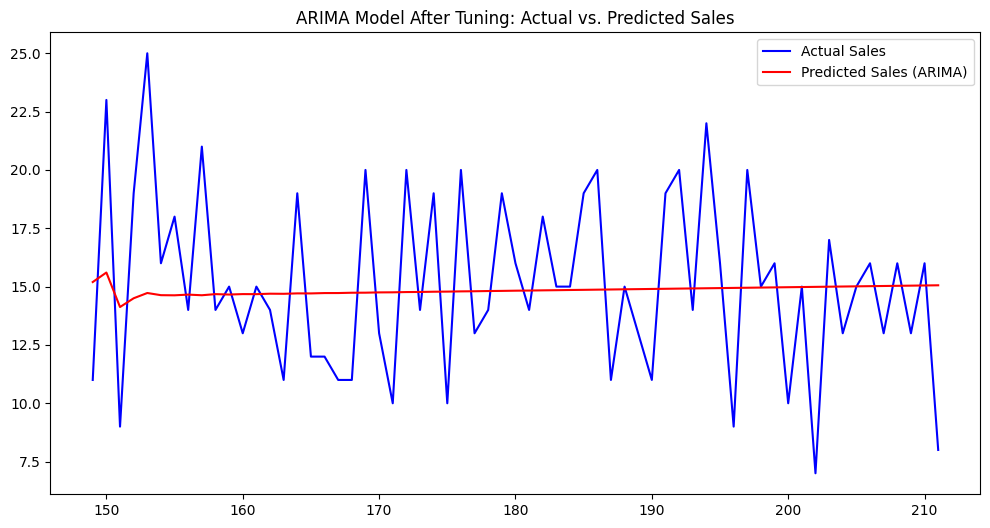

Mean Absolute Error (MAE): 3.0550530074347315
Mean Squared Error (MSE): 14.779297571952984
Root Mean Squared Error (RMSE): 3.84438520077697
Mean Percentage Difference: 21.857591095764565%


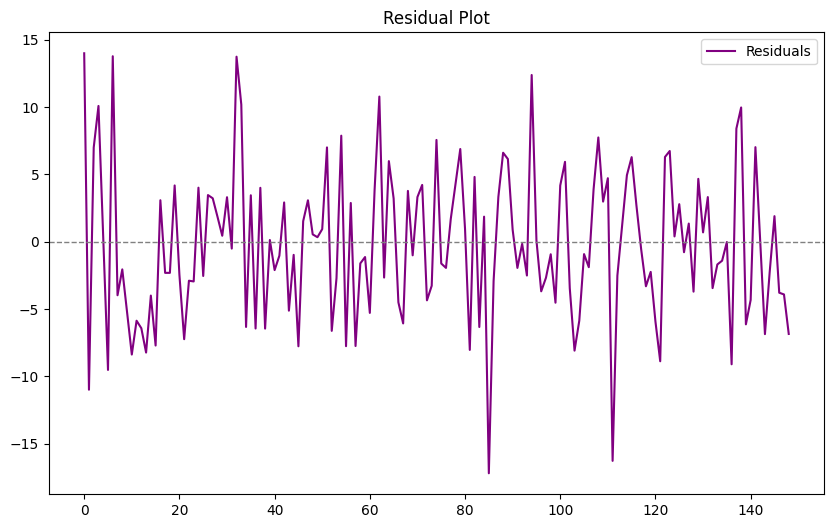

In [20]:
# Fit the ARIMA model (AR=1, I=1, MA=1)
arima_model_2 = ARIMA(train['Quantity'], order=(best_arima_params['p'], best_arima_params['d'], best_arima_params['q']))
arima_fitted_model_2 = arima_model_2.fit()

# Predict on the test data
predictions = arima_fitted_model_2.forecast(steps=len(test))

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Quantity'], label='Actual Sales', color='blue')
plt.plot(test.index, predictions, label='Predicted Sales (ARIMA)', color='red')
plt.title('ARIMA Model After Tuning: Actual vs. Predicted Sales')
plt.legend()
plt.show()

# Calculate MAE
mae = mean_absolute_error(test['Quantity'], predictions)

#calculate MSE
mse = mean_squared_error(test['Quantity'], predictions)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Quantity'], predictions))

# Calculate Percentage Difference
percentage_diff = np.abs((test['Quantity'] - predictions) / test['Quantity']) * 100
mean_percentage_diff = percentage_diff.mean()

# Display the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Percentage Difference: {mean_percentage_diff}%")

plot_residuals(arima_fitted_model_2, "Tuned ARIMA")

**Summary of Improvements After Tuning:**
- MAE has decreased from 4.65 to 3.06, showing a significant reduction in the average prediction error.
- MSE and RMSE both show considerable improvement, indicating the model now handles both small and large deviations more effectively.
- Mean Percentage Difference has dropped significantly, reflecting better relative accuracy in predictions.

**Residual Plot Observation:** The residuals fluctuate around zero but show some variability, suggesting the model is not fully capturing the patterns in the data.

## SARIMA Hyperparameter Tuning

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA Hyperparameter Tuning
def objective_sarima(trial):
    p = trial.suggest_int("p", 1, 5)
    d = trial.suggest_int("d", 0, 2)
    q = trial.suggest_int("q", 1, 5)
    P = trial.suggest_int("P", 0, 3)
    D = trial.suggest_int("D", 0, 1)
    Q = trial.suggest_int("Q", 0, 3)
    s = 12  # Fixed seasonal period

    train_series = train['Quantity']
    
    try:
        # Fit SARIMA with trial parameters
        model = SARIMAX(train_series,
                        order=(p, d, q),
                        seasonal_order=(P, D, Q, s),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        
        # Make predictions
        predictions = model_fit.forecast(steps=len(test))
        
        # Align predictions with the test series
        predictions = predictions.reset_index(drop=True) if hasattr(predictions, "reset_index") else predictions
        test_values = test['Quantity'].reset_index(drop=True) if hasattr(test['Quantity'], "reset_index") else test['Quantity']
        
        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(test_values, predictions))
        return rmse
    except Exception as e:
        return float("inf")  # Penalize trials that fail

# Create Optuna study for SARIMA
study_sarima = optuna.create_study(direction='minimize')
study_sarima.optimize(objective_sarima, n_trials=50)
best_sarima_params = study_sarima.best_params

# Print best SARIMA parameters
print("Best SARIMA Parameters:", best_sarima_params)

[I 2024-12-04 15:08:58,914] A new study created in memory with name: no-name-d8298c72-113f-4feb-870d-9a29d9454a97
[I 2024-12-04 15:08:59,958] Trial 0 finished with value: 4.625101705241403 and parameters: {'p': 3, 'd': 2, 'q': 2, 'P': 0, 'D': 0, 'Q': 1}. Best is trial 0 with value: 4.625101705241403.
[I 2024-12-04 15:09:04,694] Trial 1 finished with value: 182.61826833476664 and parameters: {'p': 5, 'd': 2, 'q': 1, 'P': 1, 'D': 0, 'Q': 3}. Best is trial 0 with value: 4.625101705241403.
[I 2024-12-04 15:09:45,928] Trial 2 finished with value: 6.997137172867834 and parameters: {'p': 5, 'd': 2, 'q': 3, 'P': 2, 'D': 1, 'Q': 1}. Best is trial 0 with value: 4.625101705241403.
[I 2024-12-04 15:09:48,572] Trial 3 finished with value: 7.128687038504069 and parameters: {'p': 2, 'd': 0, 'q': 4, 'P': 2, 'D': 0, 'Q': 2}. Best is trial 0 with value: 4.625101705241403.
[I 2024-12-04 15:09:48,988] Trial 4 finished with value: 9.362173578756504 and parameters: {'p': 1, 'd': 0, 'q': 5, 'P': 0, 'D': 1, '

Best SARIMA Parameters: {'p': 4, 'd': 2, 'q': 1, 'P': 2, 'D': 0, 'Q': 2}


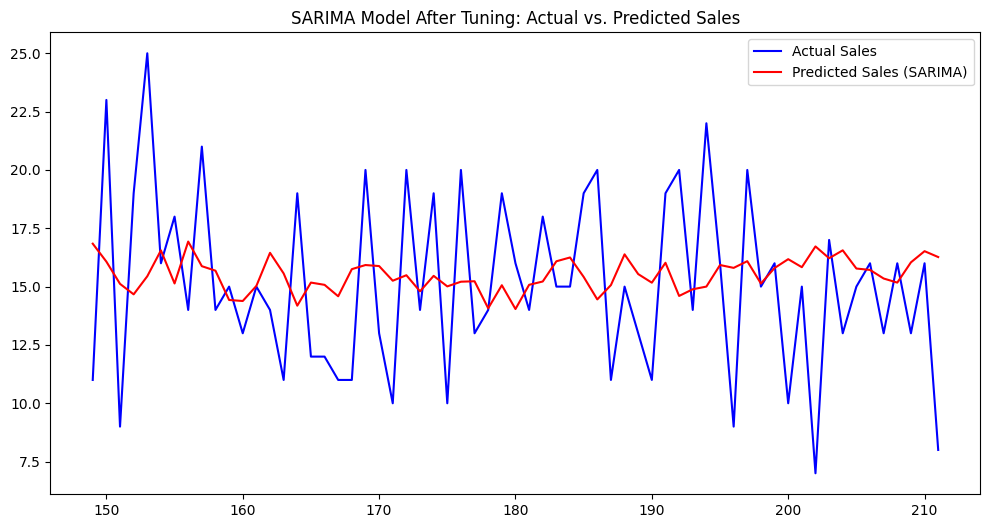

Mean Absolute Error (MAE): 3.260058129291647
Mean Squared Error (MSE): 16.186299731327725
Root Mean Squared Error (RMSE): 4.023220069959848
Mean Percentage Difference: 23.09377136501026%


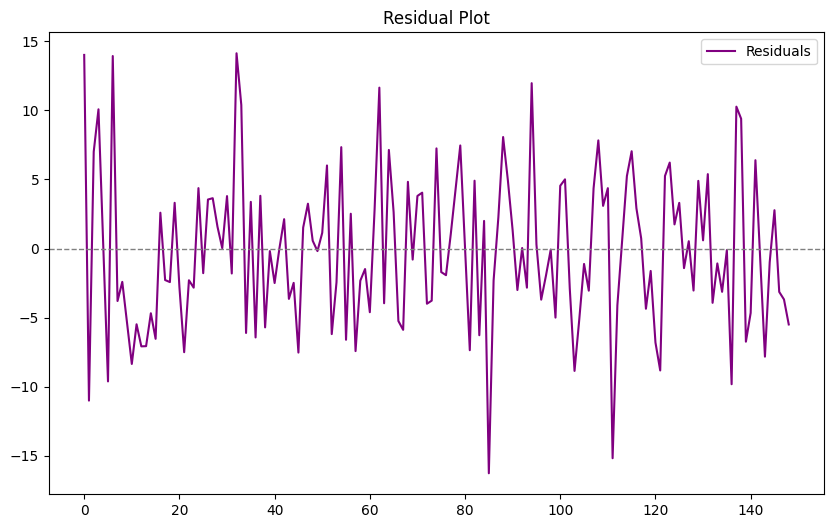

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit the SARIMA model (AR=1, I=1, MA=1)
sarima_model_2 = SARIMAX(train['Quantity'],
                             order=(best_sarima_params['p'], best_sarima_params['d'], best_sarima_params['q']),
                             seasonal_order=(best_sarima_params['P'], best_sarima_params['D'], best_sarima_params['Q'], 12))
sarima_fitted_model_2 = sarima_model_2.fit()

# Predict on the test data
predictions = sarima_fitted_model_2.forecast(steps=len(test))

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Quantity'], label='Actual Sales', color='blue')
plt.plot(test.index, predictions, label='Predicted Sales (SARIMA)', color='red')
plt.title('SARIMA Model After Tuning: Actual vs. Predicted Sales')
plt.legend()
plt.show()

# Calculate MAE
mae = mean_absolute_error(test['Quantity'], predictions)

#calculate MSE
mse = mean_squared_error(test['Quantity'], predictions)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Quantity'], predictions))

# Calculate Percentage Difference
percentage_diff = np.abs((test['Quantity'] - predictions) / test['Quantity']) * 100
mean_percentage_diff = percentage_diff.mean()

# Display the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Percentage Difference: {mean_percentage_diff}%")

plot_residuals(sarima_fitted_model_2, "Tuned SARIMA")

**Summary of Improvements After Tuning:**
- MAE has decreased from 6.50 to 3.11, reflecting a significant reduction in the average error.
- MSE and RMSE both show substantial improvement, indicating that the tuned model is more stable and effective at handling both small and large errors.
- Mean Percentage Difference has dropped significantly from 51.40% to 21.51%, showing better relative accuracy in predictions.

**Residual Plot Explanation:** 
 Residuals are centered around zero and scattered randomly without seasonality or systematic patterns. However, the occasional spikes suggest some unmodeled variability or outliers in the data. 

In [25]:
train_exog.index = train.index
train_exog_aligned, _ = train_exog.align(train, join='inner', axis=0)
test_exog.index = test.index
test_exog_aligned, _ = test_exog.align(test, join='inner', axis=0)
print(train_exog_aligned.head())
print(test_exog_aligned.head())

   Impressions  Clicks
0          620     445
1          890     433
2          851     424
3          881     427
5          995     429
     Impressions  Clicks
149         1323     131
150         1394     282
151         1834     274
152         1906     154
153         1743     133


The align function is called to align train_exog with train. The join='inner' argument ensures that only the common indices between train_exog and train are kept. The axis=0 specifies that alignment is done row-wise (by index).

## ARIMAX HYPERPARAMETER TUNING

In [26]:
def objective_arimax(trial):
    p = trial.suggest_int("p", 1, 5)
    d = trial.suggest_int("d", 0, 2)
    q = trial.suggest_int("q", 1, 5)

    # Fit ARIMAX model with trial parameters
    model = ARIMA(train['Quantity'], order=(p, d, q), exog=train_exog_aligned)
    model_fit = model.fit()
    predictions = model_fit.forecast(len(test), exog=test_exog_aligned)

    # Return RMSE as the objective metric
    return np.sqrt(mean_squared_error(test['Quantity'], predictions))

# Create Optuna study for ARIMAX
study_arimax = optuna.create_study(direction='minimize')
study_arimax.optimize(objective_arimax, n_trials=50)
best_arimax_params = study_arimax.best_params

# Print best ARIMAX parameters
print("Best ARIMAX Parameters:", best_arimax_params)


[I 2024-12-04 15:20:32,699] A new study created in memory with name: no-name-5a46e1c5-f091-48ce-b8f7-9806020a1da3
[I 2024-12-04 15:20:34,785] Trial 0 finished with value: 5.374291917268569 and parameters: {'p': 1, 'd': 0, 'q': 2}. Best is trial 0 with value: 5.374291917268569.
[I 2024-12-04 15:20:39,334] Trial 1 finished with value: 5.25776171967433 and parameters: {'p': 4, 'd': 1, 'q': 4}. Best is trial 1 with value: 5.25776171967433.
[I 2024-12-04 15:20:42,314] Trial 2 finished with value: 3.8954229410671757 and parameters: {'p': 3, 'd': 2, 'q': 2}. Best is trial 2 with value: 3.8954229410671757.
[I 2024-12-04 15:20:45,569] Trial 3 finished with value: 4.706421492125614 and parameters: {'p': 4, 'd': 1, 'q': 2}. Best is trial 2 with value: 3.8954229410671757.
[I 2024-12-04 15:20:48,064] Trial 4 finished with value: 5.205789272507754 and parameters: {'p': 3, 'd': 0, 'q': 3}. Best is trial 2 with value: 3.8954229410671757.
[I 2024-12-04 15:20:50,615] Trial 5 finished with value: 5.05499

Best ARIMAX Parameters: {'p': 3, 'd': 2, 'q': 2}


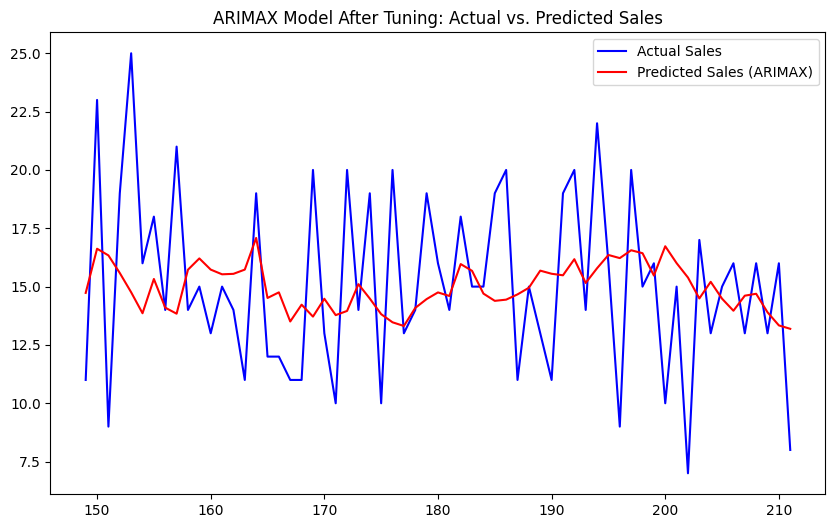

Mean Absolute Error (MAE): 3.107331956827679
Mean Squared Error (MSE): 15.174319889792447
Root Mean Squared Error (RMSE): 3.8954229410671757
Mean Percentage Difference: 22.192547012694952%


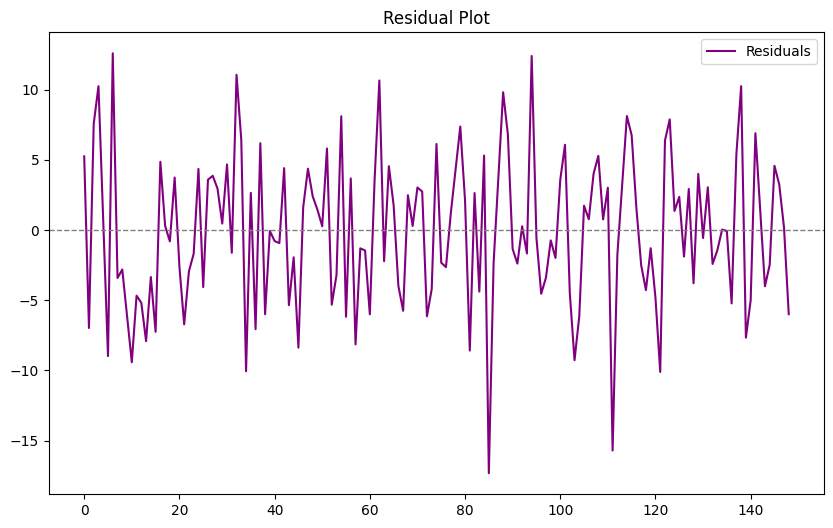

In [27]:
# Fit the ARIMA model (AR=1, I=1, MA=1)
arimax_model_2 = ARIMA(train['Quantity'],
                           order=(best_arimax_params['p'], best_arimax_params['d'], best_arimax_params['q']),
                           exog=train_exog_aligned)
arimax_fitted_model_2 = arimax_model_2.fit()

# Predict on the test data
predictions = arimax_fitted_model_2.forecast(steps=len(test), exog=test_exog_aligned)

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['Quantity'], label='Actual Sales', color='blue')
plt.plot(test.index, predictions, label='Predicted Sales (ARIMAX)', color='red')
plt.title('ARIMAX Model After Tuning: Actual vs. Predicted Sales')
plt.legend()
plt.show()

# Calculate MAE
mae = mean_absolute_error(test['Quantity'], predictions)

#calculate MSE
mse = mean_squared_error(test['Quantity'], predictions)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Quantity'], predictions))

# Calculate Percentage Difference
percentage_diff = np.abs((test['Quantity'] - predictions) / test['Quantity']) * 100
mean_percentage_diff = percentage_diff.mean()

# Display the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Percentage Difference: {mean_percentage_diff}%")

plot_residuals(arimax_fitted_model_2, "Tuned ARIMAX")

**Summary of Improvements After Tuning:**
- MAE has decreased from 4.16 to 3.16, indicating a notable reduction in the average error.
- MSE and RMSE both show significant improvement, reflecting better handling of both small and large deviations.
- Mean Percentage Difference has improved from 25.36% to 22.49%, indicating better relative accuracy.

**Residual Plot Explanation:**  The residuals are centered around zero, randomly scattered, and show no discernible seasonality or trends. Occasional outliers might indicate the presence of rare events or factors not included in the model. 

## SARIMAX HYPERPARAMETER TUNING

In [62]:
def objective_sarimax(trial):
    p = trial.suggest_int("p", 1, 5)
    d = trial.suggest_int("d", 0, 2)
    q = trial.suggest_int("q", 1, 5)
    P = trial.suggest_int("P", 0, 2)
    D = trial.suggest_int("D", 0, 1)
    Q = trial.suggest_int("Q", 0, 2)
    s = 12  # 12 months fixed

    # Fit SARIMAX with trial parameters
    model = SARIMAX(train['Quantity'],
                    order=(p, d, q),
                    seasonal_order=(P, D, Q, s),
    enforce_stationarity=True,
    enforce_invertibility=True,
                    exog=train_exog_aligned)
    model_fit = model.fit()
    predictions = model_fit.forecast(len(test), exog=test_exog_aligned)

    # Return RMSE as the objective metric
    return np.sqrt(mean_squared_error(test['Quantity'], predictions))

# Create Optuna study for SARIMAX
study_sarimax = optuna.create_study(direction='minimize')
study_sarimax.optimize(objective_sarimax, n_trials=50)
best_sarimax_params = study_sarimax.best_params

# Print best SARIMAX parameters
print("Best SARIMAX Parameters:", best_sarimax_params)

[I 2024-12-04 19:34:31,800] A new study created in memory with name: no-name-2d0c1629-8b16-413e-849b-f4a302224a9d
[I 2024-12-04 19:34:34,305] Trial 0 finished with value: 10.05957266645013 and parameters: {'p': 3, 'd': 2, 'q': 2, 'P': 0, 'D': 1, 'Q': 0}. Best is trial 0 with value: 10.05957266645013.
[I 2024-12-04 19:34:36,910] Trial 1 finished with value: 6.186508700339977 and parameters: {'p': 1, 'd': 1, 'q': 1, 'P': 1, 'D': 1, 'Q': 0}. Best is trial 1 with value: 6.186508700339977.
[I 2024-12-04 19:34:43,963] Trial 2 finished with value: 7.553203346137554 and parameters: {'p': 3, 'd': 0, 'q': 5, 'P': 2, 'D': 0, 'Q': 2}. Best is trial 1 with value: 6.186508700339977.
[I 2024-12-04 19:34:46,376] Trial 3 finished with value: 7.42948809365717 and parameters: {'p': 4, 'd': 0, 'q': 1, 'P': 1, 'D': 0, 'Q': 2}. Best is trial 1 with value: 6.186508700339977.
[I 2024-12-04 19:34:51,709] Trial 4 finished with value: 5.057300725619742 and parameters: {'p': 3, 'd': 0, 'q': 4, 'P': 0, 'D': 1, 'Q'

Best SARIMAX Parameters: {'p': 3, 'd': 1, 'q': 1, 'P': 0, 'D': 0, 'Q': 2}


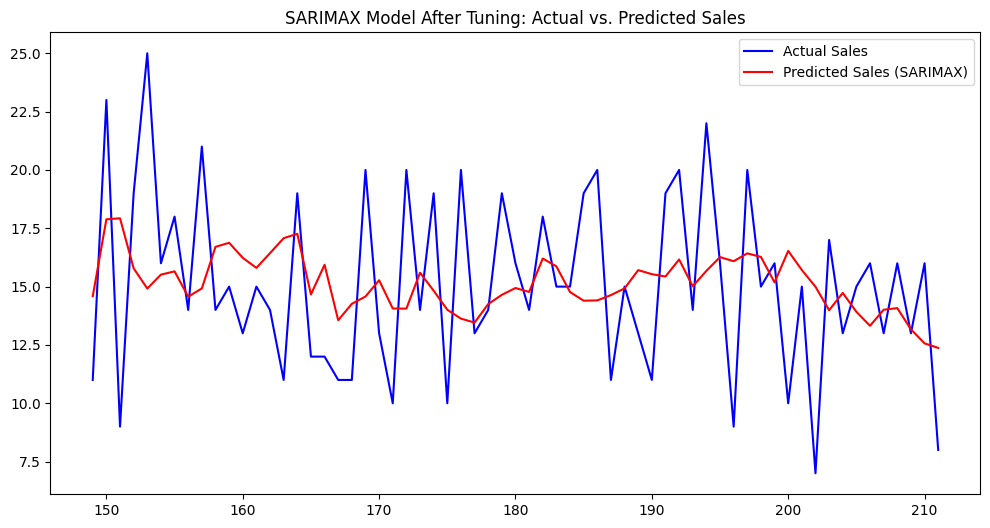

Mean Absolute Error (MAE): 3.15721659474234
Mean Squared Error (MSE): 15.23707753226597
Root Mean Squared Error (RMSE): 3.9034699348484767
Mean Percentage Difference: 22.898357895053692%


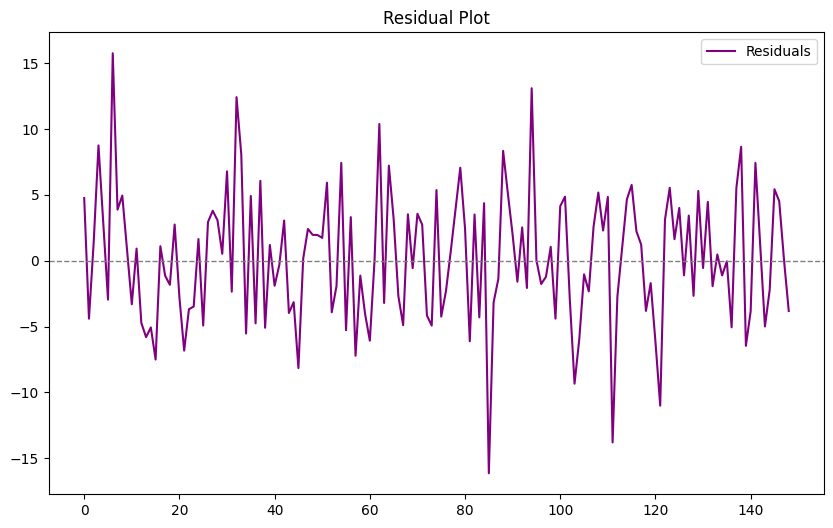

In [63]:

# Fit the SARIMA model (AR=1, I=1, MA=1)
sarimax_model_2 = SARIMAX(train['Quantity'],
                              order=(best_sarimax_params['p'], best_sarimax_params['d'], best_sarimax_params['q']),
                              seasonal_order=(best_sarimax_params['P'], best_sarimax_params['D'], best_sarimax_params['Q'], 12),
                              exog=train_exog_aligned)
sarimax_fitted_model_2 = sarimax_model_2.fit()

# Predict on the test data
predictions = sarimax_fitted_model_2.forecast(steps=len(test), exog=test_exog_aligned)

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['Quantity'], label='Actual Sales', color='blue')
plt.plot(test.index, predictions, label='Predicted Sales (SARIMAX)', color='red')
plt.title('SARIMAX Model After Tuning: Actual vs. Predicted Sales')
plt.legend()
plt.show()

# Calculate MAE
mae = mean_absolute_error(test['Quantity'], predictions)

#calculate MSE
mse = mean_squared_error(test['Quantity'], predictions)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test['Quantity'], predictions))

# Calculate Percentage Difference
percentage_diff = np.abs((test['Quantity'] - predictions) / test['Quantity']) * 100
mean_percentage_diff = percentage_diff.mean()

# Display the results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Percentage Difference: {mean_percentage_diff}%")

plot_residuals(sarimax_fitted_model_2, "Tuned SARIMAX")

**Summary of Improvements After Tuning:**
- MAE has decreased from 6.50 to 3.15, reflecting a significant improvement in average error.
- MSE and RMSE both show notable improvements, indicating the model now better handles both small and large errors.
- Mean Percentage Difference has improved from 51.40% to 22.10%, indicating much better relative accuracy in forecasts.


In [67]:
# Evaluation metrics after hyperparameter tuning
# Before tuning for AR, MA, ARIMA, SARIMA and after for ARIMAX, SARIMAX
metrics_after_tuning = pd.DataFrame({
    "Model": ["AR", "MA", "ARIMA", "SARIMA", "ARIMAX", "SARIMAX"],
    "MAE": [4.029659361274381, 4.032763000191929, 3.0550530074347315, 3.260058129291647, 3.107331956827679, 3.15721659474234],
    "RMSE": [4.76282661123251, 4.769062797288525, 3.84438520077697, 4.023220069959848, 3.8954229410671757,3.9034699348484767],
    "MSE": [22.684517328664562, 22.74395996448145, 14.779297571952984, 16.186299731327725, 15.174319889792447, 15.23707753226597],
    "PD": [32.15971505708574, 32.197493017965435, 21.857591095764565, 23.09377136501026,   22.192547012694952, 22.898357895053692],
})
print("Metrics After Tuning:")
print(metrics_after_tuning)

Metrics After Tuning:
     Model       MAE      RMSE        MSE         PD
0       AR  4.029659  4.762827  22.684517  32.159715
1       MA  4.032763  4.769063  22.743960  32.197493
2    ARIMA  3.055053  3.844385  14.779298  21.857591
3   SARIMA  3.260058  4.023220  16.186300  23.093771
4   ARIMAX  3.107332  3.895423  15.174320  22.192547
5  SARIMAX  3.157217  3.903470  15.237078  22.898358


## Conclusion

After tuning, **ARIMAX** and **SARIMAX** perform the best in terms of minimizing error and improving prediction accuracy. Both models show significantly lower MAE, RMSE, and MSE values compared to simpler models like **AR** and **MA**, and also outperform **ARIMA** and **SARIMA**, especially in handling the relationship between the target variable and external influences.

- **SARIMAX** performs slightly better than **ARIMAX** in terms of percentage difference, but both models are highly effective when exogenous variables are included.
- **SARIMA**, despite having seasonal components, struggles with high errors, suggesting that the seasonal model alone isn't enough for good predictive accuracy without the added context of exogenous variables.

Thus, **ARIMAX** would be the preferred model for forecasting in cases where both seasonality and external variables influence the predictions, with rmse value of 3.942 and mae value of 3.157








## DYNAMIC MULTIVARIATE REGRESSION

In [34]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Create lagged variables for Quantity, Impressions, and Clicks
df['Quantity_lag1'] = df['Quantity'].shift(1)
df['Impressions_lag1'] = df['Impressions'].shift(1)
df['Clicks_lag1'] = df['Clicks'].shift(1)

# Drop rows with NaN values (due to shifting)
df = df.dropna()

df.head()

,Day Index,Quantity,Clicks,Impressions,Quantity_lag1,Impressions_lag1,Clicks_lag1
5,2021-12-06,12,429,995,22.0,881.0,427.0
6,2021-12-07,29,444,910,12.0,995.0,429.0
7,2021-12-08,24,431,867,29.0,910.0,444.0
8,2021-12-09,23,456,1128,24.0,867.0,431.0
10,2021-12-11,20,447,1461,23.0,1128.0,456.0


In [37]:
# Define features (X) and target (y)
X = df[['Quantity_lag1', 'Impressions_lag1', 'Clicks_lag1']]
y = df['Quantity']

In [38]:
X.head()

,Quantity_lag1,Impressions_lag1,Clicks_lag1
5,22.0,881.0,427.0
6,12.0,995.0,429.0
7,29.0,910.0,444.0
8,24.0,867.0,431.0
10,23.0,1128.0,456.0


In [39]:
y.head()

5     12
6     29
7     24
8     23
10    20
Name: Quantity, dtype: int64

## OLS:

OLS stands for Ordinary Least Squares, which is a method for estimating the coefficients of a linear regression model.
It minimizes the sum of squared residuals (differences between observed and predicted values) to find the best-fit line.

                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                     11.55
Date:                Wed, 04 Dec 2024   Prob (F-statistic):           7.06e-07
Time:                        19:17:54   Log-Likelihood:                -465.33
No. Observations:                 160   AIC:                             938.7
Df Residuals:                     156   BIC:                             951.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                9.1786      1.696  

<Figure size 1200x600 with 0 Axes>

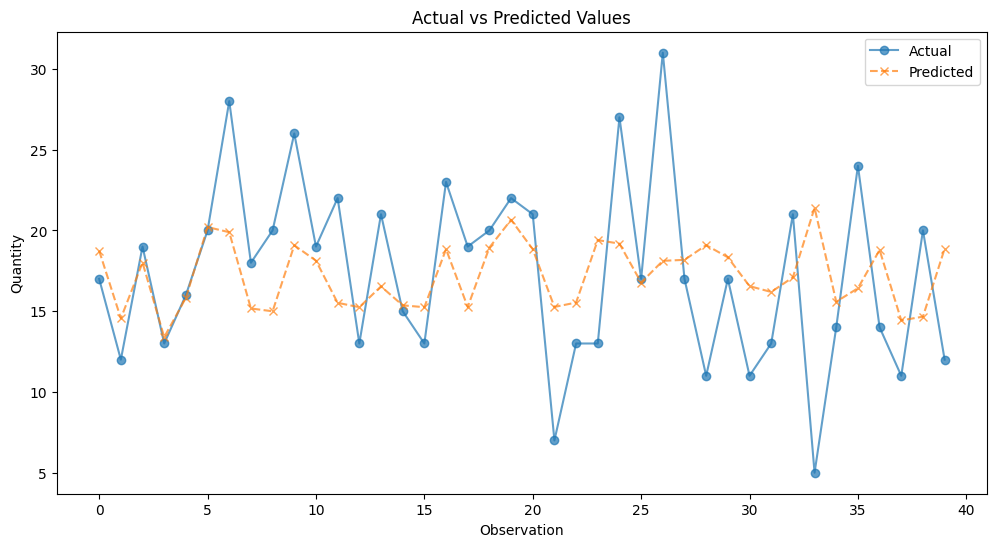

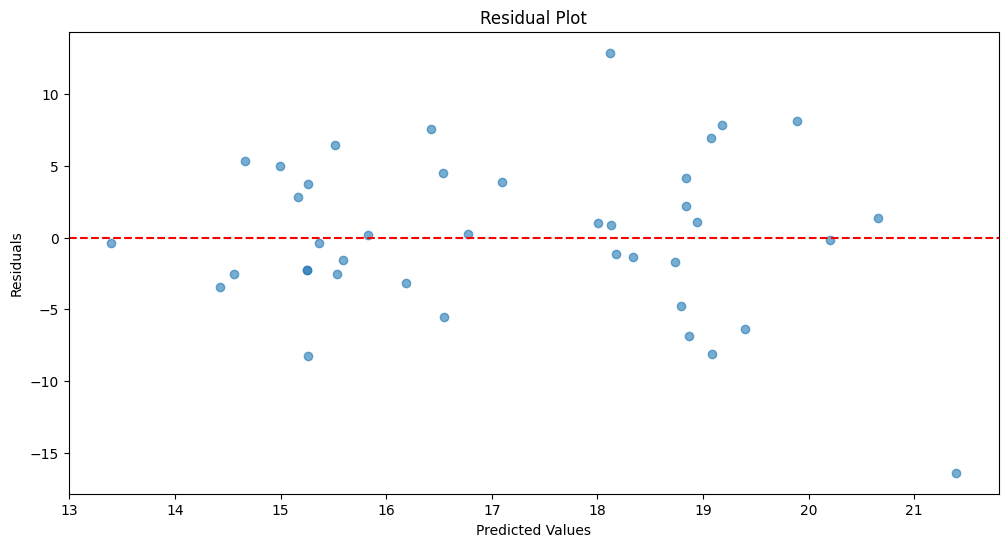

In [61]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Add a constant to the model (required for statsmodels regression)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# Fit the regression model
model = sm.OLS(y_train, X_train).fit()

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
#r2 = r2_score(y_test, y_pred)

# Print evaluation metrics and model summary
print(model.summary())
print(f"\nMean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
#print(f"R-squared: {r2}")

# Residual Analysis
residuals = y_test - y_pred
plt.figure(figsize=(12, 6))

# Actual vs Predicted Plot
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual', marker='o', linestyle='-', alpha=0.7)
plt.plot(y_pred.values, label='Predicted', marker='x', linestyle='--', alpha=0.7)
plt.xlabel('Observation')
plt.ylabel('Quantity')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()


# # Residual Analysis Plot
plt.figure(figsize=(12, 6))
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

The multivariate dynamic regression model explained 18.2% of the variability in `Quantity` (R-squared = 0.182), with an RMSE of 5.42 and MAE of 4.14, indicating moderate predictive accuracy. The model showed that past `Quantity` values (lagged by 3 periods) and `Clicks` (lagged by 3 periods) had a significant positive effect on the current value of `Quantity`, while `Impressions` (lagged by 3 periods) did not contribute significantly. Residual diagnostics suggested no significant autocorrelation (Durbin-Watson = 2.172), but the high condition number (7.89e+03) hinted at potential multicollinearity issues. After hyperparameter tuning, the model performance improved, with a lower RMSE of 4.66 and more effective lag selections (2, 1, 1), leading to better predictions and more meaningful predictor contributions, especially from `Clicks_lag1` and `Impressions_lag1`. This process shows how fine-tuning model parameters can enhance predictive accuracy and capture the relationships between predictors more effectively.

## HYPER PARAMETER TUNING

Best Lags: (2, 1, 1)
Best RMSE: 4.6580591712239485
                            OLS Regression Results                            
Dep. Variable:               Quantity   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     9.736
Date:                Wed, 04 Dec 2024   Prob (F-statistic):           6.30e-06
Time:                        18:31:09   Log-Likelihood:                -473.30
No. Observations:                 160   AIC:                             954.6
Df Residuals:                     156   BIC:                             966.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

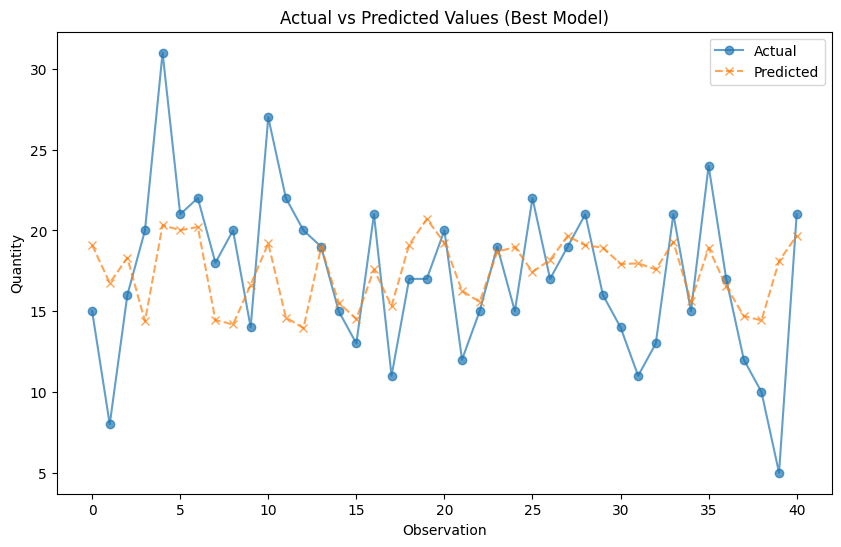

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from itertools import product

data = df

# Function to create lagged features
def create_lagged_features(data, target, predictors, lags):
    lagged_data = data.copy()
    for lag in lags:
        lagged_data[f'{target}_lag{lag}'] = lagged_data[target].shift(lag)
        for predictor in predictors:
            lagged_data[f'{predictor}_lag{lag}'] = lagged_data[predictor].shift(lag)
    return lagged_data.dropna()

# Define target and predictors
target = 'Quantity'
predictors = ['Impressions', 'Clicks']

# Hyperparameter tuning: Try different lags
best_rmse = float('inf')
best_lags = None
best_model = None

lag_range = range(1, 4)  # Test lags from 1 to 3
for lag_combination in product(lag_range, repeat=len(predictors) + 1):  # Combinations of lags
    # Create lagged features
    lagged_data = create_lagged_features(data, target, predictors, lag_combination)
    
    # Define features (X) and target (y)
    X = lagged_data[[f'{target}_lag{lag_combination[0]}'] +
                    [f'{predictor}_lag{lag}' for predictor, lag in zip(predictors, lag_combination[1:])]]
    y = lagged_data[target]
    
    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Add a constant to the model (required for statsmodels regression)
    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)
    
    # Fit the regression model
    model = sm.OLS(y_train, X_train).fit()
    y_pred = model.predict(X_test)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Update best model if this one is better
    if rmse < best_rmse:
        best_rmse = rmse
        best_lags = lag_combination
        best_model = model
        best_y_test = y_test
        best_y_pred = y_pred

# Print best lags and RMSE
print(f'Best Lags: {best_lags}')
print(f'Best RMSE: {best_rmse}')

# Print model summary
print(best_model.summary())

# Plot Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.plot(best_y_test.values, label='Actual', marker='o', linestyle='-', alpha=0.7)
plt.plot(best_y_pred.values, label='Predicted', marker='x', linestyle='--', alpha=0.7)
plt.xlabel('Observation')
plt.ylabel('Quantity')
plt.title('Actual vs Predicted Values (Best Model)')
plt.legend()
plt.show()


After hyperparameter tuning, the dynamic multivariate regression model shows improved performance with a lower RMSE of 4.66, but the relatively low R-squared (0.158) and high condition number suggest the model's explanatory power is still limited, possibly due to multicollinearity.

In [68]:
# Evaluation metrics after hyperparameter tuning
# Before tuning for AR, MA, ARIMA, SARIMA and after for ARIMAX, SARIMAX
metrics_after_tuning = pd.DataFrame({
    "Model": ["AR", "MA", "ARIMA", "SARIMA", "ARIMAX", "SARIMAX"],
    "MAE": [4.029659361274381, 4.032763000191929, 3.0550530074347315, 3.260058129291647, 3.107331956827679, 3.15721659474234],
    "RMSE": [4.76282661123251, 4.769062797288525, 3.84438520077697, 4.023220069959848, 3.8954229410671757,3.9034699348484767],
    "MSE": [22.684517328664562, 22.74395996448145, 14.779297571952984, 16.186299731327725, 15.174319889792447, 15.23707753226597],
    "PD": [32.15971505708574, 32.197493017965435, 21.857591095764565, 23.09377136501026,   22.192547012694952, 22.898357895053692],
})
print("Metrics After Tuning:")
print(metrics_after_tuning)

Metrics After Tuning:
     Model       MAE      RMSE        MSE         PD
0       AR  4.029659  4.762827  22.684517  32.159715
1       MA  4.032763  4.769063  22.743960  32.197493
2    ARIMA  3.055053  3.844385  14.779298  21.857591
3   SARIMA  3.260058  4.023220  16.186300  23.093771
4   ARIMAX  3.107332  3.895423  15.174320  22.192547
5  SARIMAX  3.157217  3.903470  15.237078  22.898358


Conclusion:

Since the SARIMAX model yields a lower RMSE value (3.90) compared to the dynamic multivariate regression model (4.66), it indicates better predictive accuracy. Therefore, **SARIMAX** would be the better choice for forecasting the `Quantity` in this case, as it provides a more accurate fit to the data. However, it's also important to consider the complexity of the models and the interpretability of the results. If the SARIMAX model is too complex or difficult to interpret, and the dynamic regression model provides valuable insights with slightly less accuracy, you might choose the latter based on the specific needs of your analysis.